In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def detect_outliers_with_polyfit(data, column, degree=2, threshold=3, plot=False):
    """
    Detects outliers based on a polynomial trend.

    Parameters:
    data (DataFrame): A pandas DataFrame with 'harv_year' and the 'column' columns.
    degree (int): The degree of the polynomial to fit. Default is 2.
    threshold (float): The Z-score threshold to identify outliers. Default is 3.

    Returns:
    DataFrame: A DataFrame containing the outliers.
    """
    # sufficient data size
    if len(data) < 5:
        return []

    # sort data
    data = data.sort_values("harv_year")
    
    # Fitting a polynomial of specified degree
    coefficients = np.polyfit(data['harv_year'], data[column], degree)
    polynomial = np.poly1d(coefficients)

    # Calculating the fitted values
    fitted_values = polynomial(data['harv_year'])

    # Calculating residuals
    residuals = data[column] - fitted_values
    #return residuals
    # Calculating Z-scores of the residuals
    std = np.std(residuals)
    data['z_score'] = residuals / std
    
    # Identifying outliers
    outliers = data[abs(data['z_score']) > threshold]

    if plot:
        plt.figure(figsize=(8, 5))
        plt.fill_between(x=data['harv_year'], y1=fitted_values - 3*std, y2=fitted_values + 3*std, color='red', label='3 standard deviations', alpha=0.15)
        plt.fill_between(x=data['harv_year'], y1=fitted_values - 2*std, y2=fitted_values + 2*std, color='seashell', label='2 standard deviations', alpha=0.9)
        plt.scatter(data['harv_year'], data[column], label='Data Points')
        plt.plot(data['harv_year'], fitted_values, color='red', label='Polynomial Fit')
        plt.scatter(outliers['harv_year'], outliers[column], color='orange', label='Outliers')
        # Annotating Z-scores on the plot
        for i, point in outliers.iterrows():
            plt.annotate(f"{abs(point['z_score']):.2f}",  # Format to 2 decimal places
                         (point['harv_year'], point[column]),
                         textcoords="offset points",  # how to position the text
                         xytext=(0,10),  # distance from text to points (x,y)
                         ha='center')  # horizontal alignment can be left, right or center
        plt.ylim(ymin=0)
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel(column)
        plt.title(f'Outlier detection based on {column} for {data[["country", "adm1", "adm2"]].values[0]}')
        plt.show()

    return outliers


def detect_suspicious_data(data, column, threshold=0.0001, plot=False):
    """
    Detect implausible consecutive yield values that are too similar,
    based on a given threshold.

    Parameters:
    - data: A pandas DataFrame with a column named 'yield'.
    - threshold: A float representing the minimum allowed difference between
                 consecutive yield values to be considered plausible.

    Returns:
    - A pandas DataFrame with implausible data.
    """
    
    # sort data
    data = data.sort_values("harv_year")
    
    # Calculate the absolute difference between consecutive yield values
    data[column + '_diff'] = data[column].diff().abs()

    # Filter out the rows where the yield difference is below the threshold
    threshold_surpassed = data[column + '_diff'].values < threshold
    for i, x in enumerate(threshold_surpassed):
        if x:
            threshold_surpassed[i-1] = True
    suspicious_df = data[threshold_surpassed].copy()

    if plot:
        plt.figure(figsize=(8, 5))
        plt.scatter(data['harv_year'], data[column], label='Data points')
        plt.scatter(suspicious_df['harv_year'], suspicious_df[column], color='orange', label=f'Suspicious {column} data')
        # Annotating Z-scores on the plot
        for i, point in suspicious_df.iterrows():
            plt.annotate(f"{point[column]:.5f}",  # Format to 3 decimal places
                         (point['harv_year'], point[column]),
                         textcoords="offset points",  # how to position the text
                         xytext=(0,10),  # distance from text to points (x,y)
                         ha='center', rotation=90)  # horizontal alignment can be left, right or center
        plt.ylim(ymin=0)
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel(column)
        plt.title(f'Suspicious data detection based on {column} for {data[["country", "adm1", "adm2"]].values[0]}')
        plt.show()
        
    return suspicious_df
    
def is_close(a, b, rel_tol=0.01):
    return abs(a-b) <= rel_tol * max(abs(a), abs(b))
    
def my_merge(df1, df2, on, rel_tol=0.01):
    assert np.all(~df1.isna()), "Found na value in df1. Check it out."
    assert np.all(~df2.isna()), "Found na value in df2. Check it out."
    # make lists for indicies to keep
    index1 = list(df1.index)
    index2 = list(df2.index)
    n_inconsistency = 0
    n_consistency = 0
    for i, row1 in df1.iterrows():
        # find match
        for j, row2 in df2.iterrows():
            if np.all(row1[on] == row2[on]):
                if is_close(a=row1["yield"], b=row2["yield"], rel_tol=rel_tol):
                    n_consistency += 1
                    index2.remove(j)
                else:
                    print(f'Found inconsistency for {row1[on].values}: {row1["yield"]} | {row2["yield"]}')
                    n_inconsistency += 1
                    index1.remove(i)
                    index2.remove(j)
                break
    # merge together the remaining data
    merged_df = pd.concat([df1.loc[index1], df2.loc[index2]]).reset_index()
    if n_inconsistency:
        print(f"Found {n_inconsistency} inconsistencies.")
        print(f"Remaining datapoints after merge: {len(merged_df)} (both: {n_consistency}, df1: {len(index1) - n_consistency}, df2: {len(index2)})")
    else:
        print(f"Datapoints after merge: {len(merged_df)} (both: {n_consistency}, df1: {len(index1) - n_consistency}, df2: {len(index2)})")
    return merged_df

## Kenya & Zambia

In [ ]:
# Load data into a pandas DataFrame
raw_yield_df = pd.read_csv("Yield/burkinafaso_kenya_zambia/adm_crop_production_BF_KE_ZM.csv", header=None)
raw_yield_df = raw_yield_df[[country in ["Zambia", "Kenya"] for country in raw_yield_df[2]]]
raw_yield_df = raw_yield_df[[crop == "Maize" for crop in raw_yield_df[7]]]
yield_df = pd.DataFrame()
yield_df["country"] = raw_yield_df[2] 
yield_df["adm1"] = raw_yield_df[4] 
yield_df["adm2"] = raw_yield_df[5] 
yield_df["adm2"][yield_df["adm2"] == "none"] = "None"
yield_df["season"] = raw_yield_df[8] 
yield_df["harv_year"] = raw_yield_df[11] 
yield_df["indicator"] = raw_yield_df[14] 
yield_df["value"] = raw_yield_df[15] 
# drop duplicates
yield_df = yield_df.drop_duplicates()
# if duplicates are found by leaving out the value, those duplicates have unequal values are have to be discarded
duplicates = yield_df.duplicated(subset=['country', 'adm1', 'adm2', 'season', 'harv_year', 'indicator'], keep=False)
if any(duplicates):
    print(f"{sum(duplicates) / 6} duplicates found")
    # Keep only the rows that are not duplicates
    yield_df = yield_df[~duplicates]
yield_df = yield_df.pivot(index=['country', 'adm1', 'adm2', 'season', 'harv_year'],
                      columns='indicator', values='value').reset_index()
yield_df = yield_df.dropna(subset=["yield"])
# too few short season datapoints for Kenya
yield_df = yield_df[yield_df.season != 'Short']
yield_df.head()

## Malawi

In [ ]:
raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_south_africa.csv")#, header=None)
malawi_yield_df = raw_yield_df[raw_yield_df.country == "Malawi"].copy()
print(len(malawi_yield_df))
# filtering irrigation season and others
malawi_yield_df = malawi_yield_df[malawi_yield_df.crop_production_system == "Rainfed (PS)"]
malawi_yield_df = malawi_yield_df.rename(columns={"admin_1": "adm1", "admin_2": "adm2", "season_name": "season"})
malawi_yield_df.loc[malawi_yield_df["adm2"] == "none", "adm2"] = "None"
malawi_yield_df["harv_year"] = [int(date[:4]) for date in malawi_yield_df.season_date]
malawi_yield_df = malawi_yield_df[["country", 'adm1', 'adm2', 'season', 'harv_year', 'indicator', 'value']]
print(len(malawi_yield_df))
# drop duplicates
malawi_yield_df = malawi_yield_df.drop_duplicates()
print(len(malawi_yield_df))
# if duplicates are found by leaving out the value, those duplicates have unequal values are have to be discarded
duplicates = malawi_yield_df.duplicated(subset=['country', 'adm1', 'adm2', 'season', 'harv_year', 'indicator'], keep=False)
if any(duplicates):
    print(f"{sum(duplicates) / 6} duplicates found")
    duplicate_df = malawi_yield_df[duplicates]
    # Keep only the rows that are not duplicates
    malawi_yield_df = malawi_yield_df[~duplicates]
print(len(malawi_yield_df))
malawi_yield_df = malawi_yield_df.pivot(index=['country', 'adm1', 'adm2', 'season', 'harv_year'],
                      columns='indicator', values='value').reset_index()
malawi_yield_df = malawi_yield_df.rename(columns={"Area Planted": "area", "Quantity Produced": "production", "Yield": "yield"})
malawi_yield_df = malawi_yield_df.dropna(subset=["yield"])
print(len(malawi_yield_df))
malawi_yield_df.head()

In [ ]:
yield_df = pd.concat([yield_df, malawi_yield_df]).reset_index()

## Ethiopia

In [25]:
print("FEWS NET:")
raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_east_africa.csv")#, header=None)
raw_yield_df["country"] = raw_yield_df.admin_0
ethiopia_yield_df = raw_yield_df[raw_yield_df.country == "Ethiopia"].copy()
# 
#ethiopia_yield_df = ethiopia_yield_df[[x not in ['Zanzibar Central/South', 'Zanzibar North', 'Zanzibar Urban/West'] for x in tanzania_yield_df.admin_1]]
print(len(ethiopia_yield_df))
ethiopia_yield_df = ethiopia_yield_df.rename(columns={"admin_1": "adm1", "admin_2": "adm2", "season_name": "season"})
ethiopia_yield_df.loc[ethiopia_yield_df["adm2"] == "none", "adm2"] = "None"
ethiopia_yield_df["harv_year"] = [int(date[:4]) for date in ethiopia_yield_df.season_date]
ethiopia_yield_df = ethiopia_yield_df[["country", 'adm1', 'adm2', 'season', 'harv_year', 'indicator', 'value']]
print(len(ethiopia_yield_df))
# drop duplicates
ethiopia_yield_df = ethiopia_yield_df.drop_duplicates()
print(len(ethiopia_yield_df))
# if duplicates are found by leaving out the value, those duplicates have unequal values are have to be discarded
duplicates = ethiopia_yield_df.duplicated(subset=['country', 'adm1', 'adm2', 'season', 'harv_year', 'indicator'], keep=False)
if any(duplicates):
    print(f"{sum(duplicates) / 6} duplicates found")
    duplicate_df = ethiopia_yield_df[duplicates]
    # Keep only the rows that are not duplicates
    ethiopia_yield_df = ethiopia_yield_df[~duplicates]
print(len(ethiopia_yield_df))
ethiopia_yield_df = ethiopia_yield_df.pivot(index=['country', 'adm1', 'adm2', 'season', 'harv_year'],
                      columns='indicator', values='value').reset_index()
ethiopia_yield_df = ethiopia_yield_df.rename(columns={"Area Planted": "area", "Quantity Produced": "production", "Yield": "yield"})
ethiopia_yield_df = ethiopia_yield_df.dropna(subset=["yield"])
print(len(ethiopia_yield_df))
ethiopia_yield_df.head()

FEWS NET:
4663
4663
4637
14.5 duplicates found
4550
1092


C:\Users\janz\AppData\Local\Temp\ipykernel_3492\3344369806.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_east_africa.csv")#, header=None)


indicator,country,adm1,adm2,season,harv_year,Area Harvested,area,production,yield
3,Ethiopia,Addis Ababa,Region 14,Meher,2000,NaN,20.00,21.000,1.050000
5,Ethiopia,Addis Ababa,Region 14,Meher,2002,NaN,64.95,19.041,0.293164
6,Ethiopia,Addis Ababa,Region 14,Meher,2004,NaN,66.00,20.300,0.307576
7,Ethiopia,Addis Ababa,Region 14,Meher,2005,NaN,13.00,10.400,0.800000
8,Ethiopia,Addis Ababa,Region 14,Meher,2006,NaN,11.72,5.347,0.456229


## Tanzania

In [138]:
print("FEWS NET:")
raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_east_africa.csv")#, header=None)
raw_yield_df["country"] = raw_yield_df.admin_0
tanzania_yield_df = raw_yield_df[raw_yield_df.country == "Tanzania"].copy()
# filter unimportant data for the island Zanzibar 
tanzania_yield_df = tanzania_yield_df[[x not in ['Zanzibar Central/South', 'Zanzibar North', 'Zanzibar Urban/West'] for x in tanzania_yield_df.admin_1]]
print(len(tanzania_yield_df))
tanzania_yield_df = tanzania_yield_df.rename(columns={"admin_1": "adm1", "admin_2": "adm2", "season_name": "season"})
tanzania_yield_df.loc[tanzania_yield_df["adm2"] == "none", "adm2"] = "None"
tanzania_yield_df["harv_year"] = [int(date[:4]) for date in tanzania_yield_df.season_date]
tanzania_yield_df = tanzania_yield_df[["country", 'adm1', 'adm2', 'season', 'harv_year', 'indicator', 'value']]
print(len(tanzania_yield_df))
# drop duplicates
tanzania_yield_df = tanzania_yield_df.drop_duplicates()
print(len(tanzania_yield_df))
# if duplicates are found by leaving out the value, those duplicates have unequal values are have to be discarded
duplicates = tanzania_yield_df.duplicated(subset=['country', 'adm1', 'adm2', 'season', 'harv_year', 'indicator'], keep=False)
if any(duplicates):
    print(f"{sum(duplicates) / 6} duplicates found")
    duplicate_df = tanzania_yield_df[duplicates]
    # Keep only the rows that are not duplicates
    tanzania_yield_df = tanzania_yield_df[~duplicates]
print(len(tanzania_yield_df))
tanzania_yield_df = tanzania_yield_df.pivot(index=['country', 'adm1', 'adm2', 'season', 'harv_year'],
                      columns='indicator', values='value').reset_index()
# for Tanzania there is almost only yield data accoring to the harvested area. Thats why we'll drop the datapoints with only planted area
tanzania_yield_df = tanzania_yield_df.rename(columns={"Area Harvested": "area", "Quantity Produced": "production", "Yield": "yield"})
tanzania_yield_df = tanzania_yield_df.dropna(subset=["yield", "area", "production"])
tanzania_yield_df = tanzania_yield_df.drop("Area Planted", axis=1)
tanzania_yield_df.loc[tanzania_yield_df["adm2"].isna(), "adm2"] = "None"
# too few datapoints with seasonality 
tanzania_yield_df = tanzania_yield_df[tanzania_yield_df.season == 'Annual']
# calculate yield again (because its rounded sometimes)
tanzania_yield_df["yield"] = tanzania_yield_df["production"] / tanzania_yield_df["area"]

print(len(tanzania_yield_df))

print("\nMinistry:")
raw_tanzania_yield_df = pd.read_csv("Yield/tanzania/tanzania_maize_region_2009_2019.csv")
tanzania_yield_df_2 = pd.DataFrame({"country": np.repeat("Tanzania", len(raw_tanzania_yield_df)),
                                 "adm1": raw_tanzania_yield_df["region_name_original"],
                                 "harv_year": raw_tanzania_yield_df["harv_year"],
                                 "production": raw_tanzania_yield_df["production "],
                                 "area": raw_tanzania_yield_df["area"],
                                 "yield": raw_tanzania_yield_df["yield "]})
tanzania_yield_df_2["season"] = "Annual"
tanzania_yield_df_2["adm2"] = "None"
# calculate yield again (because its rounded sometimes)
tanzania_yield_df_2["yield"] = tanzania_yield_df_2["production"] / tanzania_yield_df_2["area"]
print(len(tanzania_yield_df_2))

xy = my_merge(tanzania_yield_df, tanzania_yield_df_2, on=["adm1", "adm2", "harv_year", "season"], rel_tol=0.1)


FEWS NET:
1710
1710
1710
1710
218

Ministry:
250


C:\Users\janz\AppData\Local\Temp\ipykernel_7396\3357102657.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_east_africa.csv")#, header=None)


Found inconsistency for ['Arusha' 'None' 2012 'Annual']: 0.699998386784539 | 1.6999999997591368
Found inconsistency for ['Arusha' 'None' 2013 'Annual']: 1.2000015954815961 | 0.7000000000000001
Found inconsistency for ['Dar es Salaam' 'None' 2011 'Annual']: 0.5999999999992193 | 0.29999999995435905
Found inconsistency for ['Dar es Salaam' 'None' 2013 'Annual']: 0.6 | 0.3000000001027969
Found inconsistency for ['Dodoma' 'None' 2011 'Annual']: 0.5000000000000353 | 0.8999999997082544
Found inconsistency for ['Dodoma' 'None' 2013 'Annual']: 0.5 | 0.6
Found inconsistency for ['Kagera' 'None' 2011 'Annual']: 2.0 | 1.4000000006066557
Found inconsistency for ['Kigoma' 'None' 2011 'Annual']: 1.9999999999999618 | 1.5999999997986176
Found inconsistency for ['Kigoma' 'None' 2013 'Annual']: 1.9999952505794294 | 1.699999999955436
Found inconsistency for ['Kilimanjaro' 'None' 2011 'Annual']: 1.0 | 0.899999999970499
Found inconsistency for ['Kilimanjaro' 'None' 2013 'Annual']: 1.0 | 0.8999999999999999
F

In [3]:
print("FEWS NET:")
raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_east_africa.csv")#, header=None)
raw_yield_df["country"] = raw_yield_df.admin_0
tanzania_yield_df = raw_yield_df[raw_yield_df.country == "Tanzania"].copy()
# filter unimportant data for the island Zanzibar 
tanzania_yield_df = tanzania_yield_df[[x not in ['Zanzibar Central/South', 'Zanzibar North', 'Zanzibar Urban/West'] for x in tanzania_yield_df.admin_1]]
print(len(tanzania_yield_df))
tanzania_yield_df = tanzania_yield_df.rename(columns={"admin_1": "adm1", "admin_2": "adm2", "season_name": "season"})
# we filter als admin 2 datapoints because of limited data
tanzania_yield_df = tanzania_yield_df[tanzania_yield_df["adm2"].isna()]
tanzania_yield_df.loc[tanzania_yield_df["adm2"].isna(), "adm2"] = "None"
tanzania_yield_df["harv_year"] = [int(date[:4]) for date in tanzania_yield_df.season_date]
tanzania_yield_df = tanzania_yield_df[["country", 'adm1', 'adm2', 'season', 'harv_year', 'indicator', 'value']]
print(len(tanzania_yield_df))
# drop duplicates
tanzania_yield_df = tanzania_yield_df.drop_duplicates()
print(len(tanzania_yield_df))
# if duplicates are found by leaving out the value, those duplicates have unequal values are have to be discarded
duplicates = tanzania_yield_df.duplicated(subset=['country', 'adm1', 'adm2', 'season', 'harv_year', 'indicator'], keep=False)
if any(duplicates):
    print(f"{sum(duplicates) / 6} duplicates found")
    duplicate_df = tanzania_yield_df[duplicates]
    # Keep only the rows that are not duplicates
    tanzania_yield_df = tanzania_yield_df[~duplicates]
print(len(tanzania_yield_df))
tanzania_yield_df = tanzania_yield_df.pivot(index=['country', 'adm1', 'adm2', 'season', 'harv_year'],
                      columns='indicator', values='value').reset_index()
# for Tanzania there is almost only yield data accoring to the harvested area. Thats why we'll drop the datapoints with only planted area
tanzania_yield_df = tanzania_yield_df.rename(columns={"Area Harvested": "area", "Quantity Produced": "production", "Yield": "yield"})
tanzania_yield_df = tanzania_yield_df.dropna(subset=["yield", "area", "production"])
tanzania_yield_df = tanzania_yield_df.drop("Area Planted", axis=1)
# too few datapoints with seasonality 
tanzania_yield_df = tanzania_yield_df[tanzania_yield_df.season == 'Annual']
# calculate yield again (because its rounded sometimes)
tanzania_yield_df["yield"] = tanzania_yield_df["production"] / tanzania_yield_df["area"]
print(len(tanzania_yield_df))

print("From report:")
raw_tanzania_yield_df = pd.read_csv("Yield/tanzania/tanzania_yield_from_pdf.csv", sep=" ", na_values="-", dtype={"2011": float, "2011": float, "2012": float, "2013": float, "2014": float, "2015": float, "2016": float, "2017": float, "2018": float, "2019": float})
my_regions = ["Arusha", 'Dar es Salaam', 'Dodoma', 'Geita', 'Iringa',
        'Kagera', 'Katavi', 'Kigoma', 'Kilimanjaro', 'Lindi', 'Manyara',
        'Mara', 'Mbeya', 'Morogoro', 'Mtwara', 'Mwanza', 'Njombe',
        'Pwani', 'Rukwa', 'Ruvuma',
        'Shinyanga', 'Simiyu', 'Singida', 'Songwe', 'Tabora', 'Tanga']
area_ls = []
production_ls = []
yield_ls = []
for i, region in enumerate(my_regions):
    area_ls.append(raw_tanzania_yield_df.values[i*3, 2:])
    production_ls.append(raw_tanzania_yield_df.values[1 + i*3, 2:])
    yield_ls.append(raw_tanzania_yield_df.values[2 + i*3, 2:])
tanzania_yield_df_2 = pd.DataFrame({"adm1": np.repeat(my_regions, 10),
                        "harv_year": np.tile(np.arange(2011, 2021), len(my_regions)),
                        "area": np.array(area_ls).astype("float").flatten() * 1000,
                        "production": np.array(production_ls).astype("float").flatten()* 1000,
                        "yield": np.array(yield_ls).astype("float").flatten()})
tanzania_yield_df_2["country"] = "Tanzania"
tanzania_yield_df_2["adm2"] = "None"
tanzania_yield_df_2["season"] = "Annual"
tanzania_yield_df_2 = tanzania_yield_df_2.dropna()
# calculate yield again (because its rounded sometimes)
tanzania_yield_df_2["yield"] = tanzania_yield_df_2["production"] / tanzania_yield_df_2["area"]

xy = my_merge(tanzania_yield_df, tanzania_yield_df_2, on=["adm1", "adm2", "harv_year", "season"], rel_tol=0.1)

FEWS NET:
1710
552
552
552
88
From report:
Found inconsistency for ['Arusha' 'None' 2013 'Annual']: 1.2000015954815961 | 1.0405612545690366


C:\Users\janz\AppData\Local\Temp\ipykernel_11600\2630386852.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_yield_df = pd.read_csv("Yield/FEWS NET/maize_yield_east_africa.csv")#, header=None)


Found inconsistency for ['Dar es Salaam' 'None' 2011 'Annual']: 0.5999999999992193 | 0.2993827160493827
Found inconsistency for ['Dar es Salaam' 'None' 2013 'Annual']: 0.6 | 0.8461538461538461
Found inconsistency for ['Dodoma' 'None' 2011 'Annual']: 0.5000000000000353 | 0.6000191791331032
Found inconsistency for ['Dodoma' 'None' 2013 'Annual']: 0.5 | 0.7224159931943853
Found inconsistency for ['Kagera' 'None' 2011 'Annual']: 2.0 | 1.5000379161295214
Found inconsistency for ['Kagera' 'None' 2013 'Annual']: 2.0 | 2.3351660682226214
Found inconsistency for ['Kagera' 'None' 2014 'Annual']: 2.0 | 2.4784647257660017
Found inconsistency for ['Katavi' 'None' 2013 'Annual']: 2.1000003901236304 | 1.3888328965934287
Found inconsistency for ['Kigoma' 'None' 2011 'Annual']: 1.9999999999999618 | 1.5999597241101546
Found inconsistency for ['Kilimanjaro' 'None' 2013 'Annual']: 1.0 | 1.20105627390275
Found inconsistency for ['Lindi' 'None' 2011 'Annual']: 0.4000000000000394 | 0.5
Found inconsistency fo

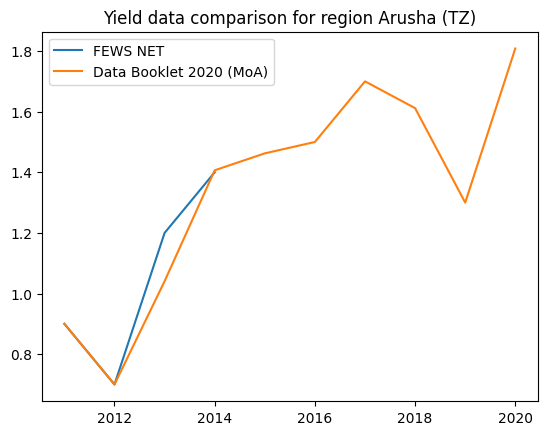

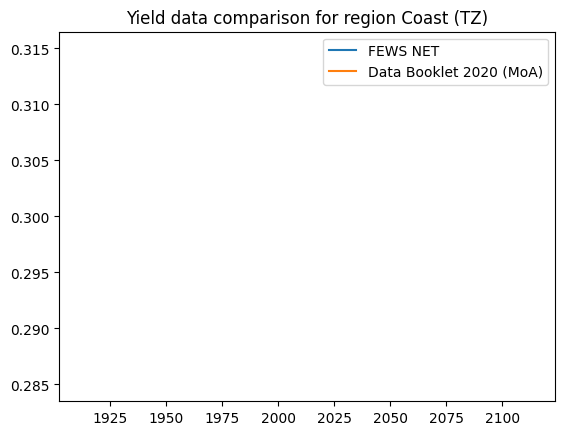

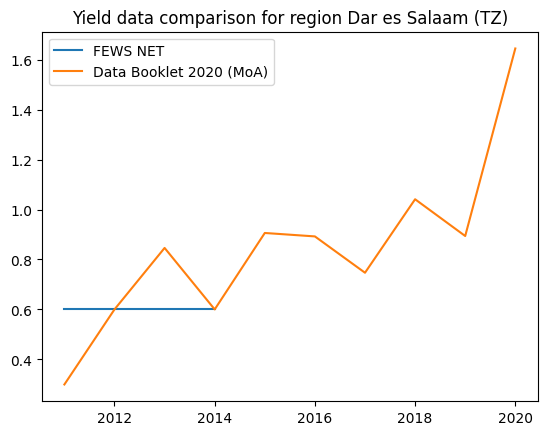

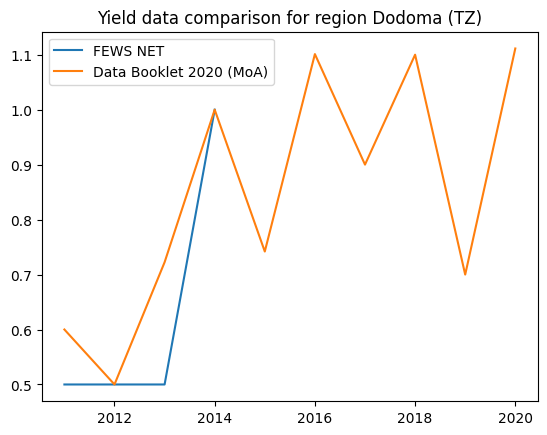

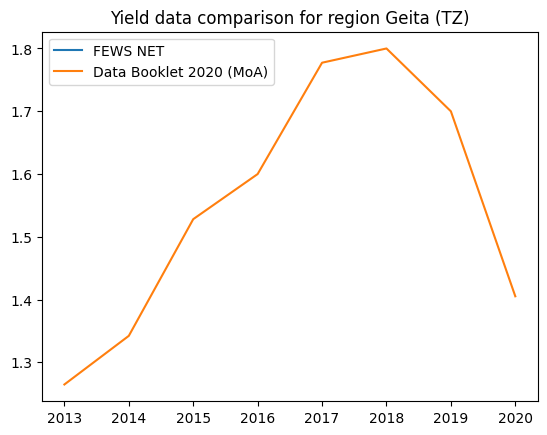

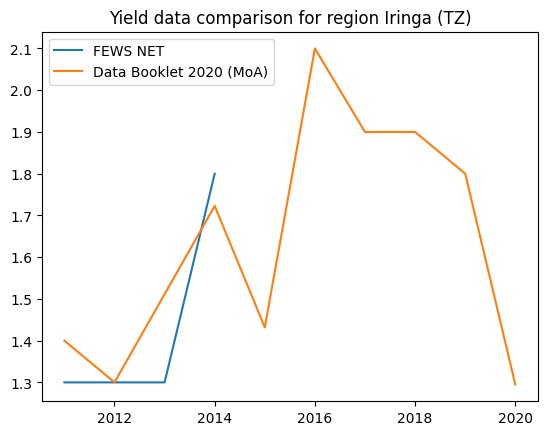

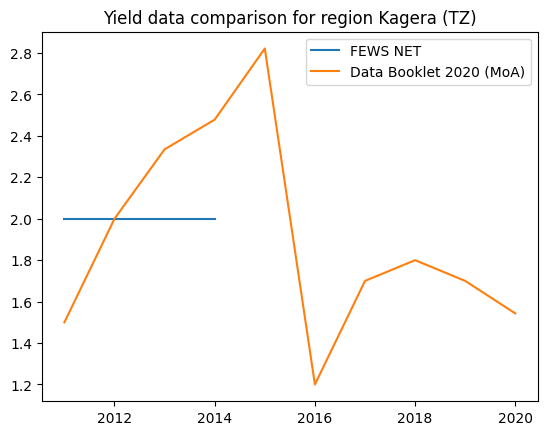

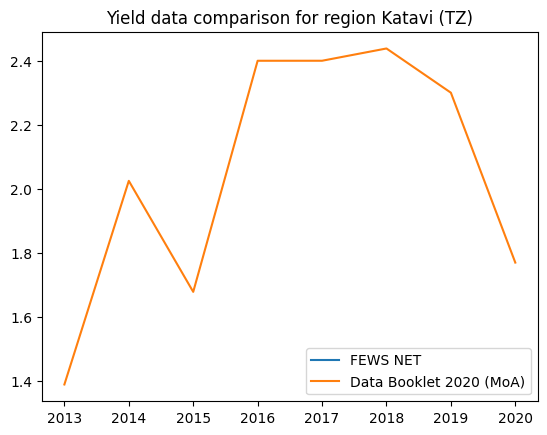

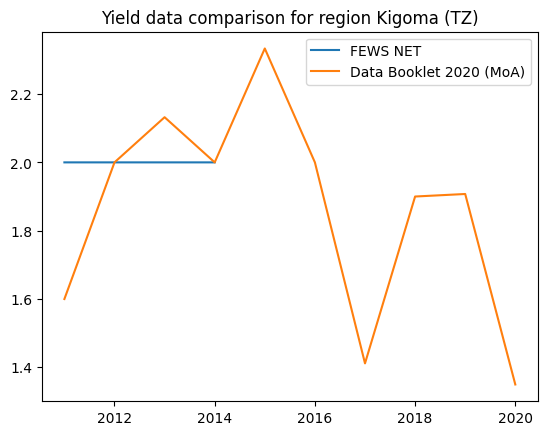

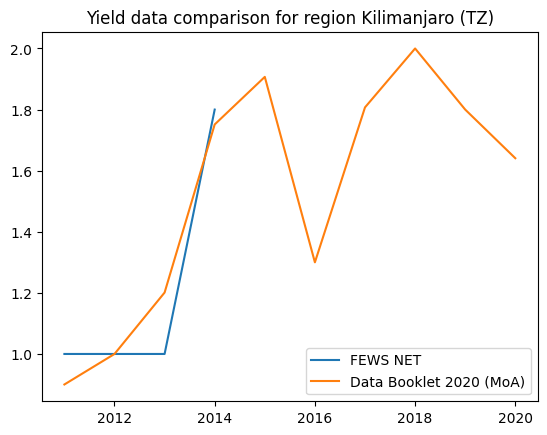

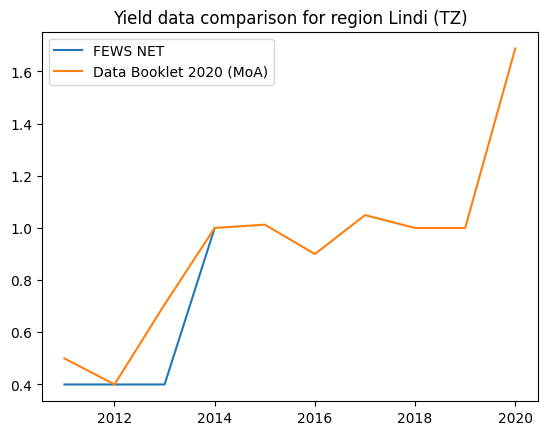

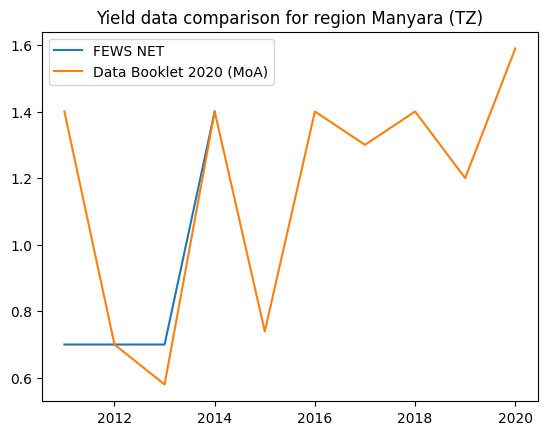

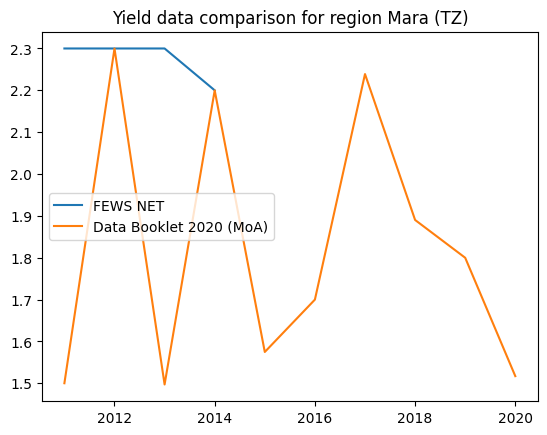

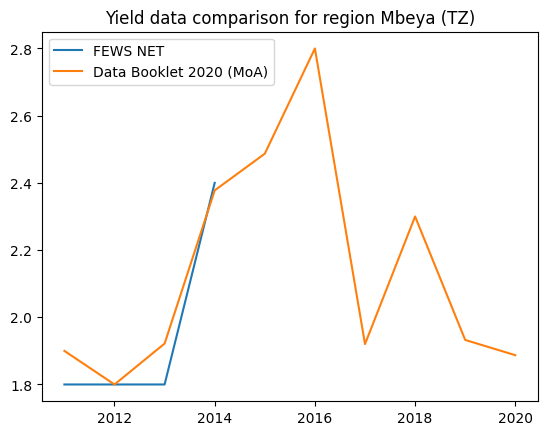

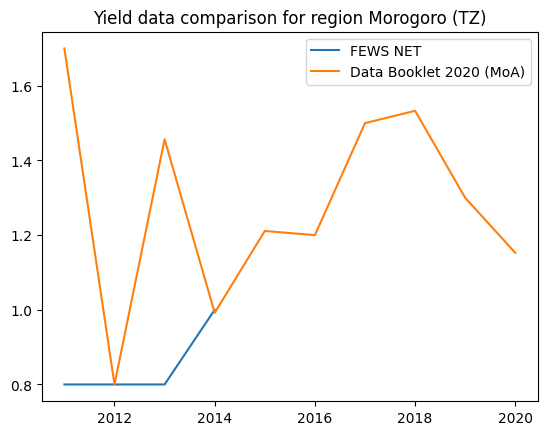

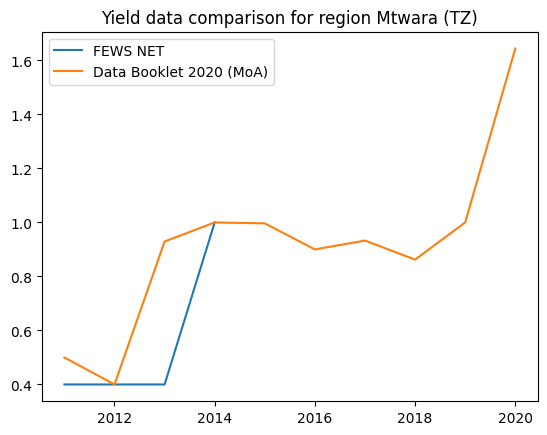

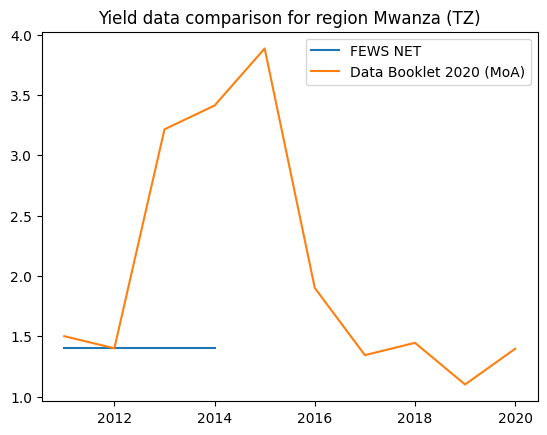

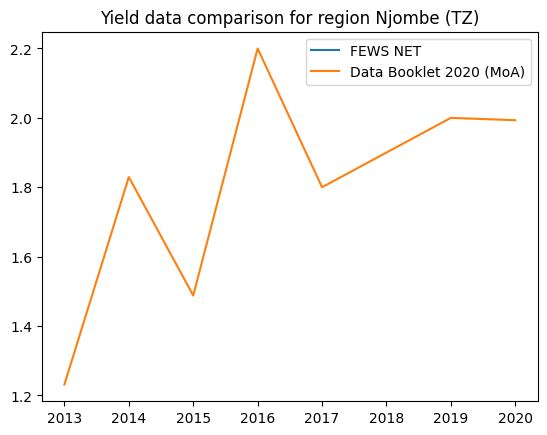

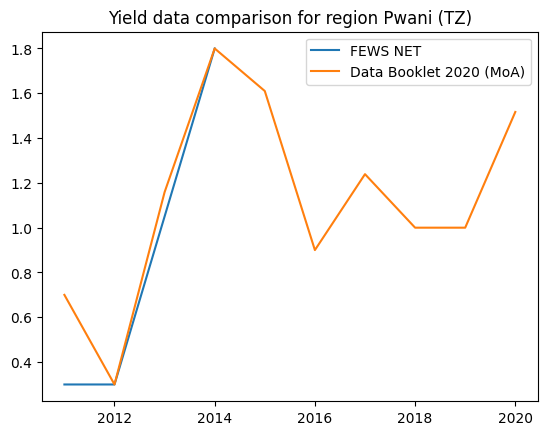

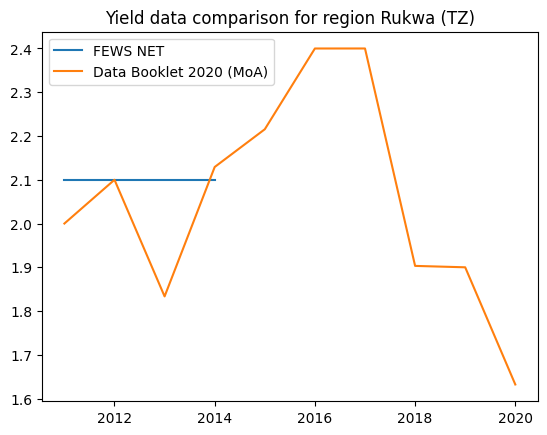

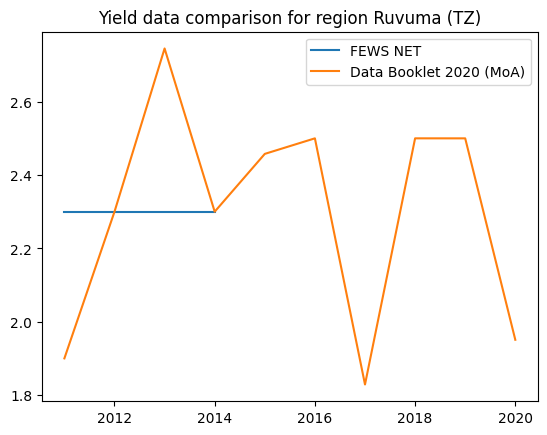

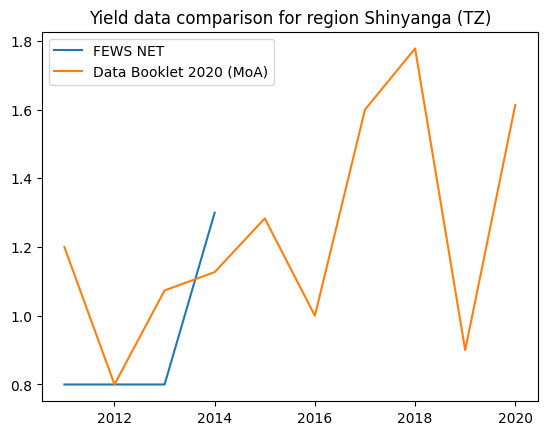

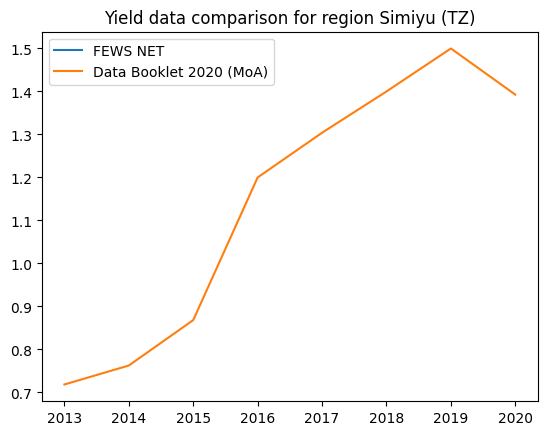

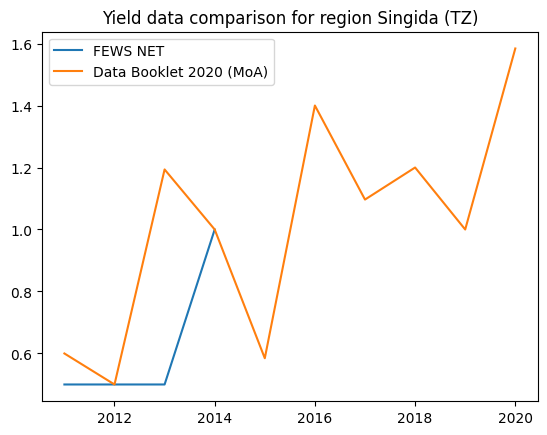

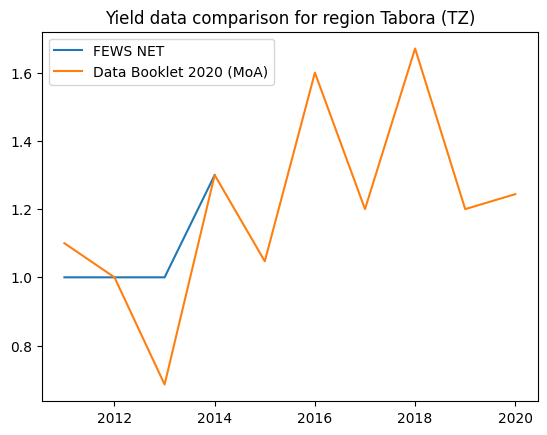

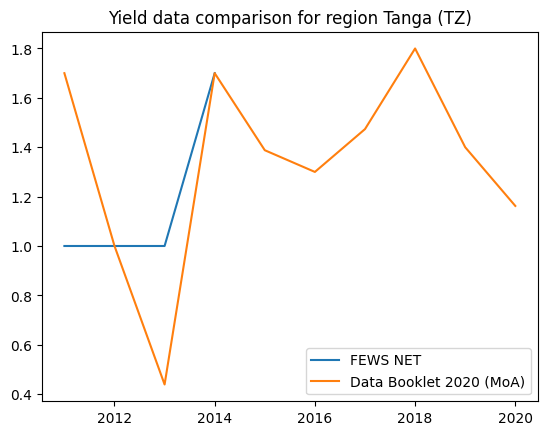

In [9]:
for region in np.unique(tanzania_yield_df.adm1):
    region_df_1 = tanzania_yield_df[tanzania_yield_df.adm1 == region]
    region_df_2 = tanzania_yield_df_2[tanzania_yield_df_2.adm1 == region]
    plt.plot(region_df_1.harv_year, region_df_1["yield"], label="FEWS NET")
    plt.plot(region_df_2.harv_year, region_df_2["yield"], label="Data Booklet 2020 (MoA)")
    plt.legend()
    plt.title("Yield data comparison for region " + region + " (TZ)")
    plt.savefig(region, dpi=200)
    plt.show()

In [6]:
tanzania_yield_df[tanzania_yield_df.adm1 == "Rukwa"]

indicator,country,adm1,adm2,season,harv_year,area,production,yield
101,Tanzania,Rukwa,None,Annual,2011,249582.686844,524123.642371,2.1
102,Tanzania,Rukwa,None,Annual,2012,249428.000000,523798.800000,2.1
103,Tanzania,Rukwa,None,Annual,2013,256329.000000,538290.900000,2.1
104,Tanzania,Rukwa,None,Annual,2014,256604.000000,538868.400000,2.1


In [136]:
print("From report:")
raw_tanzania_yield_df = pd.read_csv("Yield/tanzania/tanzania_yield_from_pdf.csv", sep=" ", na_values="-", dtype={"2011": float, "2011": float, "2012": float, "2013": float, "2014": float, "2015": float, "2016": float, "2017": float, "2018": float, "2019": float})
my_regions = ["Arusha", 'Dar es Salaam', 'Dodoma', 'Geita', 'Iringa',
        'Kagera', 'Katavi', 'Kigoma', 'Kilimanjaro', 'Lindi', 'Manyara',
        'Mara', 'Mbeya', 'Morogoro', 'Mtwara', 'Mwanza', 'Njombe',
        'Pwani', 'Rukwa', 'Ruvuma',
        'Shinyanga', 'Simiyu', 'Singida', 'Songwe', 'Tabora', 'Tanga']
area_ls = []
production_ls = []
yield_ls = []
for i, region in enumerate(my_regions):
    area_ls.append(raw_tanzania_yield_df.values[i*3, 2:])
    production_ls.append(raw_tanzania_yield_df.values[1 + i*3, 2:])
    yield_ls.append(raw_tanzania_yield_df.values[2 + i*3, 2:])
tanzania_yield_df = pd.DataFrame({"adm1": np.repeat(my_regions, 10),
                        "harv_year": np.tile(np.arange(2011, 2021), len(my_regions)),
                        "area": np.array(area_ls).astype("float").flatten() * 1000,
                        "production": np.array(production_ls).astype("float").flatten()* 1000,
                        "yield": np.array(yield_ls).astype("float").flatten()})
tanzania_yield_df["country"] = "Tanzania"
tanzania_yield_df["adm2"] = "None"
tanzania_yield_df["season"] = "Annual"
tanzania_yield_df = tanzania_yield_df.dropna()
# calculate yield again (because its rounded sometimes)
tanzania_yield_df["yield"] = tanzania_yield_df["production"] / tanzania_yield_df["area"]



print("\nMinistry:")
raw_tanzania_yield_df = pd.read_csv("Yield/tanzania/tanzania_maize_region_2009_2019.csv")
tanzania_yield_df_2 = pd.DataFrame({"country": np.repeat("Tanzania", len(raw_tanzania_yield_df)),
                                 "adm1": raw_tanzania_yield_df["region_name_original"],
                                 "harv_year": raw_tanzania_yield_df["harv_year"],
                                 "production": raw_tanzania_yield_df["production "],
                                 "area": raw_tanzania_yield_df["area"],
                                 "yield": raw_tanzania_yield_df["yield "]})
tanzania_yield_df_2["season"] = "Annual"
tanzania_yield_df_2["adm2"] = "None"
# calculate yield again (because its rounded sometimes)
tanzania_yield_df_2["yield"] = tanzania_yield_df_2["production"] / tanzania_yield_df_2["area"]
print(len(tanzania_yield_df_2))

xy = my_merge(tanzania_yield_df, tanzania_yield_df_2, on=["adm1", "adm2", "harv_year", "season"], rel_tol=0.10)

From report:

Ministry:
250
Found inconsistency for ['Arusha' 'None' 2012 'Annual']: 0.6999516050975964 | 1.6999999997591368
Found inconsistency for ['Arusha' 'None' 2013 'Annual']: 1.0405612545690366 | 0.7000000000000001
Found inconsistency for ['Arusha' 'None' 2015 'Annual']: 1.46245325355273 | 1.196795952813633
Found inconsistency for ['Dar es Salaam' 'None' 2013 'Annual']: 0.8461538461538461 | 0.3000000001027969
Found inconsistency for ['Dar es Salaam' 'None' 2015 'Annual']: 0.9060773480662984 | 0.5105077470180472
Found inconsistency for ['Dodoma' 'None' 2011 'Annual']: 0.6000191791331032 | 0.8999999997082544
Found inconsistency for ['Dodoma' 'None' 2013 'Annual']: 0.7224159931943853 | 0.6
Found inconsistency for ['Dodoma' 'None' 2015 'Annual']: 0.7419109250095166 | 0.850846245248338
Found inconsistency for ['Kigoma' 'None' 2013 'Annual']: 2.1322064347542056 | 1.699999999955436
Found inconsistency for ['Kigoma' 'None' 2015 'Annual']: 2.3334296028880868 | 1.7016924904939674
Found in

## Investigate Armed Conflicts

In [ ]:
country = "Kenya"
yield_mean_df = yield_df[(yield_df.country == country)].groupby("harv_year").mean("yield").reset_index()
plt.plot(yield_mean_df.harv_year, yield_mean_df["yield"], alpha=0.6)

for year, text in zip([1993, 2008], ["1993: Post-election year with ~1,500 fatalities", "2008: Post-election year with ~1,133 fatalities"]):
    point = yield_mean_df[yield_mean_df.harv_year == year]
    plt.scatter(point['harv_year'], point["yield"], color="red")
    plt.annotate(text,  
                 (point['harv_year'], point["yield"]),
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center')  # horizontal alignment can be left, right or center
plt.title("Political instability impact on crop yield for Kenya")
plt.ylabel("Avg Crop Yield")

In [ ]:
ucdp = pd.read_csv("General/gedevents-2024-04-19.csv", index_col=False)
print(ucdp.columns)
deaths_sum_df = ucdp.groupby("year")["best_est"].sum("best_est").reset_index()

In [26]:
acled = pd.read_csv("General/1997-01-01-2024-04-26-Eastern_Africa-Southern_Africa-Ethiopia-Kenya-Malawi-Tanzania-Zambia.csv", index_col=False)
acled = acled[acled.country == "Ethiopia"]
print(acled.columns)
deaths_sum_df = acled.groupby("year")["fatalities"].sum("fatalities").reset_index()

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')


In [34]:
ethiopia_yield_df[ethiopia_yield_df.harv_year == 2017].head(50)

indicator,country,adm1,adm2,season,harv_year,Area Harvested,area,production,yield
17,Ethiopia,Afar,NaN,Belg,2017,NaN,19651.65,3.469865e+04,1.765686
59,Ethiopia,Amhara,NaN,Belg,2017,NaN,34717.62,4.012303e+04,1.155696
70,Ethiopia,Amhara,Argoba,Meher,2017,NaN,315.18,7.921156e+02,2.513216
87,Ethiopia,Amhara,Awi,Meher,2017,NaN,69659.00,3.033019e+05,4.354095
104,Ethiopia,Amhara,East Gojam,Meher,2017,NaN,74398.18,3.370097e+05,4.529811
121,Ethiopia,Amhara,North Gondar,Meher,2017,NaN,73586.84,2.595437e+05,3.527040
138,Ethiopia,Amhara,North Shewa (AM),Meher,2017,NaN,7716.57,2.534112e+04,3.283988
155,Ethiopia,Amhara,North Wollo,Meher,2017,NaN,7745.40,1.706744e+04,2.203558
172,Ethiopia,Amhara,Oromia,Meher,2017,NaN,3803.30,9.758845e+03,2.565889
189,Ethiopia,Amhara,South Gondar,Meher,2017,NaN,54633.67,1.831024e+05,3.351457


In [31]:
yield_mean_df

indicator,harv_year,Area Harvested,area,production,yield
0,1994,NaN,183242.857143,205528.571429,0.935509
1,1996,NaN,16081.666667,24480.333333,1.539519
2,1997,NaN,14230.000000,24795.500000,1.422622
3,1998,NaN,23156.304348,40067.413043,1.545479
4,1999,NaN,28623.913043,50216.000000,1.551139
5,2000,NaN,27448.510638,49000.595745,1.502476
6,2001,NaN,35644.166667,65257.145833,1.574123
7,2002,NaN,23290.932931,49082.292466,1.649490
8,2004,NaN,23388.086207,43734.777586,1.510488
9,2005,NaN,23679.120690,40927.687931,1.410030


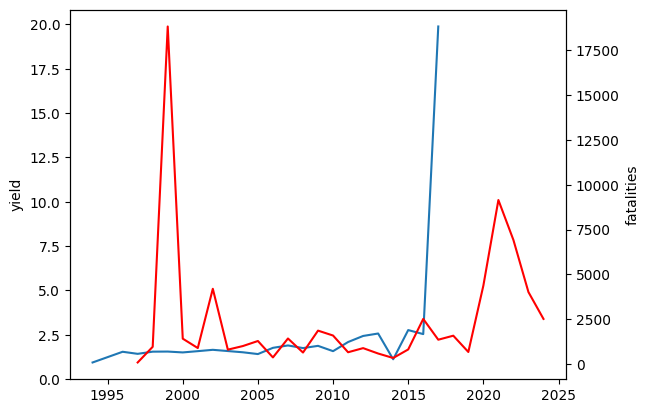

In [30]:
country = "Ethiopia"
yield_mean_df = ethiopia_yield_df[(ethiopia_yield_df.country == country)].groupby("harv_year").mean("yield").reset_index()
fig, ax1 = plt.subplots()
ax1.plot(yield_mean_df.harv_year, yield_mean_df["yield"])
ax1.set_ylabel("yield")
ax2 = ax1.twinx()
ax2.plot(deaths_sum_df.year, deaths_sum_df.fatalities, color= "red")
ax2.set_ylabel("fatalities")
plt.show()

In [ ]:
yield_mean_df["year"] = yield_mean_df["harv_year"] - 1
merged_df = pd.merge(yield_mean_df, deaths_sum_df, on="year", how="inner")
plt.scatter(merged_df["fatalities"], merged_df["yield"])
plt.show()

In [ ]:
country = "Zambia"
yield_mean_df = yield_df[(yield_df.country == country)].groupby("harv_year").mean("yield").reset_index()
plt.plot(yield_mean_df.harv_year, yield_mean_df["yield"], alpha=0.6)

for year, text in zip([2016, 2011], ["2016", "2011"]):
    point = yield_mean_df[yield_mean_df.harv_year == year]
    plt.scatter(point['harv_year'], point["yield"], color="red")
    plt.annotate(text,  
                 (point['harv_year'], point["yield"]),
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center')  # horizontal alignment can be left, right or center

In [ ]:
yield_df[~yield_df.adm2.isna()]

### Further Filtering

In [38]:
yield_df = ethiopia_yield_df

Discard 6 datapoints from Region 14 (Ethiopia) due to avg planted area of 34ha
Discard 1 datapoints from Zone 5 (Ethiopia) due to avg planted area of 110ha
Discard 8 datapoints from Argoba (Ethiopia) due to avg planted area of 437ha
Discard 16 datapoints from Dire Dawa (Ethiopia) due to avg planted area of 293ha
Discard 7 datapoints from Itang (Ethiopia) due to avg planted area of 916ha
Discard 7 datapoints from Mezhenger (Ethiopia) due to avg planted area of 358ha
Discard 11 datapoints from Shinile (Ethiopia) due to avg planted area of 157ha
Discard 1 datapoints from Sitti (Ethiopia) due to avg planted area of 334ha
Discard 53 datapoints from due to small planted area (of <1000ha)


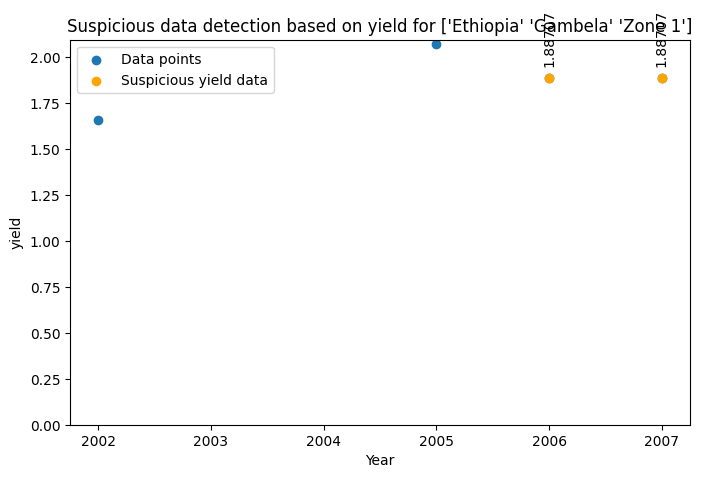

Discard 2 suspicious 'yield'-values from ('Ethiopia', 'Gambela', 'Zone 1').


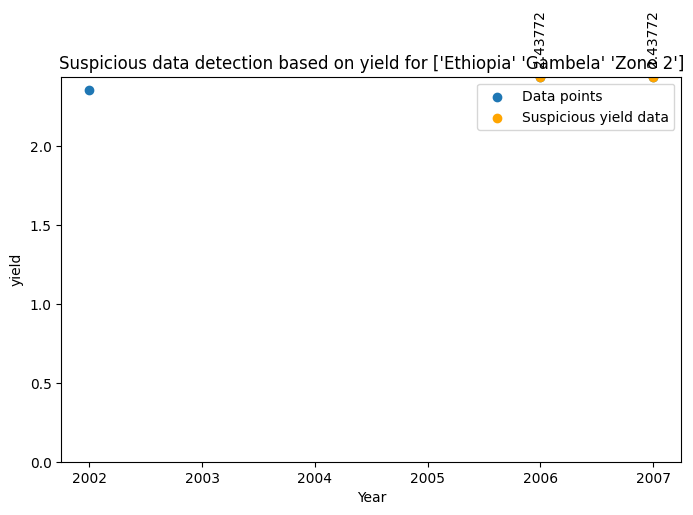

Discard 2 suspicious 'yield'-values from ('Ethiopia', 'Gambela', 'Zone 2').


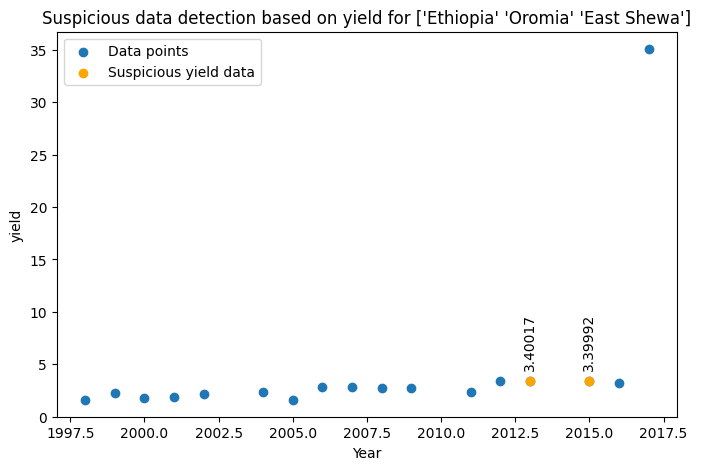

Discard 2 suspicious 'yield'-values from ('Ethiopia', 'Oromia', 'East Shewa').
Discard 35 datapoints with unrealistic yields (>= 10 t/ha)
Discard 1 outliers in 'area' from ('Ethiopia', 'Amhara', 'North Wollo') with Z-scores of [3.00678519]
Discard 1 outliers in 'area' from ('Ethiopia', 'Oromia', 'Borena') with Z-scores of [3.13711945]


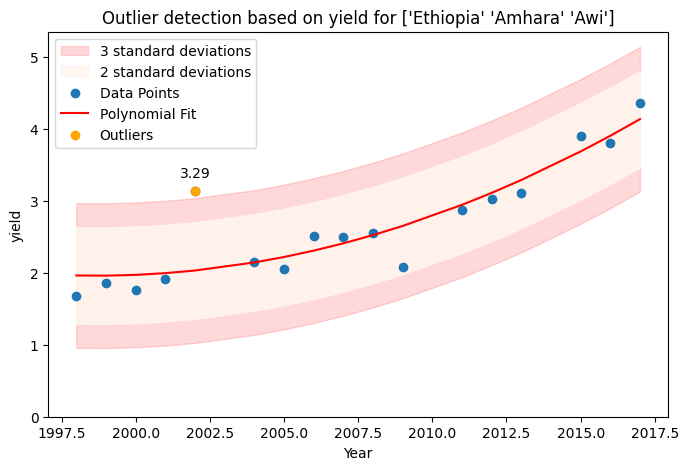

indicator   country    adm1 adm2 season  harv_year  Area Harvested      area  \
75         Ethiopia  Amhara  Awi  Meher       2002             NaN  34085.13   

indicator  production    yield   z_score  
75         106725.979  3.13116  3.285053  
Discard 1 outliers in 'yield' from ('Ethiopia', 'Amhara', 'Awi') with Z-scores of [3.28505303]
Discard 1 datapoints from Awusi (Ethiopia) due to little number of datapoints in this area.
Discard 1 datapoints from Gabi (Ethiopia) due to little number of datapoints in this area.
Discard 4 datapoints from Zone 3 (Ethiopia) due to little number of datapoints in this area.
Discard 7 datapoints from Mao-Komo (Ethiopia) due to little number of datapoints in this area.
Discard 5 datapoints from Agniwak (Ethiopia) due to little number of datapoints in this area.
Discard 4 datapoints from Nuer (Ethiopia) due to little number of datapoints in this area.
Discard 14 datapoints from Zone 1 (Ethiopia) due to little number of datapoints in this area.
Discard 

In [39]:
# group columns for which each individual has only one yield value per year
group_columns = ["country", "adm1", "adm2", "season"]

# 1. Check if yield, production and area are consistent
yield_values = yield_df["yield"].copy()
yield_df["yield"] = (yield_df["production"] / yield_df.area)
yield_inconsistencies = abs(yield_df["yield"] - yield_values) >= 0.05
if sum(yield_inconsistencies) > 0:
    print(f"Found {sum(yield_inconsistencies)} yield inconsistencies. Check them out: yield_inconsistency_df")
    yield_inconsistency_df = yield_df[yield_inconsistencies]
    yield_inconsistency_df["yield_in_database"] = yield_values[yield_inconsistencies]
    yield_df = yield_df[~yield_inconsistencies]

# 2. filter crisis events like political instability
yield_df = yield_df[~((yield_df.country == "Kenya") & (yield_df.harv_year == 1993))] # post-election crisis
yield_df = yield_df[~((yield_df.country == "Kenya") & (yield_df.harv_year == 2008))] # 2007–2008 Kenyan crisis
yield_df = yield_df[~((yield_df.country == "Kenya") & (yield_df.harv_year == 2009))] # 2007–2008 Kenyan crisis

# 3.1 filter based on avg planted area:
min_area = 1000
avg_df = yield_df.groupby(group_columns).mean("area").reset_index()
for _, row in avg_df[avg_df.area < min_area].iterrows():
    region_ix = yield_df[group_columns] == row[group_columns]
    yield_df = yield_df[~region_ix]
    print(f"Discard {sum(region_ix)} datapoints from {row.adm1} ({row.country}) due to avg planted area of {round(row.area)}ha")

# 3.2 filter based on planted area for each datapoint
too_small = yield_df.area < min_area
print(f"Discard {sum(too_small)} datapoints from due to small planted area (of <{min_area}ha)")
yield_df = yield_df[~too_small]

# 4. filter suspicious data (consecutive equal values)
for group, group_df in yield_df.groupby(group_columns):
    sus_df = detect_suspicious_data(region_df, column = "yield", threshold=1e-3)
    if len(sus_df) > 0:
        detect_suspicious_data(region_df, column = "yield", threshold=1e-3, plot=True)
        print(f"Discard {len(sus_df)} suspicious 'yield'-values from {region}.")
        yield_df = yield_df.drop(index=sus_df.index)

# 5.1 filter unrealistic yields 
max_yield = 10
unrealistic_yield = yield_df["yield"] >= 10
if sum(unrealistic_yield):
    print(f"Discard {sum(unrealistic_yield)} datapoints with unrealistic yields (>= {max_yield} t/ha)")
    yield_df = yield_df[~unrealistic_yield]

# 5.2 filter outliers in the planted area based on Z-scores and 3-sigma margin 
for region, region_df in yield_df.groupby(["country", "adm1", "adm2"]):
    outlier_df = detect_outliers_with_polyfit(region_df, column="area")
    if len(outlier_df) > 0:
        print(f"Discard {len(outlier_df)} outliers in 'area' from {region} with Z-scores of {outlier_df.z_score.values}")
        yield_df = yield_df.drop(index=outlier_df.index)
        
# 5.3 filter outliers in yield based on Z-scores and 3-sigma margin 
for region, region_df in yield_df.groupby(["country", "adm1", "adm2"]):
    outlier_df = detect_outliers_with_polyfit(region_df, column="yield")
    if len(outlier_df) > 0:
        print(detect_outliers_with_polyfit(region_df, column="yield", plot=True))
        outlier_df = outlier_df[outlier_df.z_score > 0]
        if len(outlier_df) > 0:
            print(f"Discard {len(outlier_df)} outliers in 'yield' from {region} with Z-scores of {outlier_df.z_score.values}")
            yield_df = yield_df.drop(index=outlier_df.index)

# 6. filter regions with few datapoints
min_datapoints = 10
count_datapoints = yield_df.groupby().count().reset_index()
for _, row in count_datapoints[count_datapoints["yield"] < 10].iterrows():
    if row.country in ["Kenya", "Tanzania"]:
        region_ix = yield_df.adm1 == row.adm1
        yield_df = yield_df[~region_ix]
        print(f"Discard {sum(region_ix)} datapoints from {row.adm1} ({row.country}) due to little number of datapoints in this area.")
    elif row.country in ["Zambia", "Malawi", "Ethiopia"]:
        region_ix = yield_df.adm2 == row.adm2
        yield_df = yield_df[~region_ix]
        print(f"Discard {sum(region_ix)} datapoints from {row.adm2} ({row.country}) due to little number of datapoints in this area.")
    else:
        raise AssertionError(row.country)

In [ ]:
region_df

In [ ]:
yield_df

In [ ]:
yield_df.head(50)

In [ ]:
sus_df.index

In [ ]:
yield_inconsistency_df

In [ ]:
tanzania_yield_df

In [ ]:
yield_df.groupby("adm1").count()

In [ ]:

raw_tanzania_yield_df = pd.read_csv("Yield/tanzania/tanzania_maize_region_2009_2019.csv")
tanzania_yield_df = pd.DataFrame({"country": np.repeat("Tanzania", len(raw_tanzania_yield_df)),
                                 "adm1": raw_tanzania_yield_df["region_name_original"],
                                 "harv_year": raw_tanzania_yield_df["harv_year"],
                                 "yield": raw_tanzania_yield_df["yield "]})

Data from a second source is used for validating the yield data.

In [5]:
raw_tanzania_yield_2_df = pd.read_csv("Yield/tanzania/tanzania_yield_from_pdf.csv", sep=" ", na_values="-", dtype={"2011": float, "2011": float, "2012": float, "2013": float, "2014": float, "2015": float, "2016": float, "2017": float, "2018": float, "2019": float})
my_regions = ["Arusha", 'Dar es Salaam', 'Dodoma', 'Geita', 'Iringa',
        'Kagera', 'Katavi', 'Kigoma', 'Kilimanjaro', 'Lindi', 'Manyara',
        'Mara', 'Mbeya', 'Morogoro', 'Mtwara', 'Mwanza', 'Njombe',
        'Pwani', 'Rukwa', 'Ruvuma',
        'Shinyanga', 'Simiyu', 'Singida', 'Songwe', 'Tabora', 'Tanga']
area_ls = []
production_ls = []
yield_ls = []
for i, region in enumerate(my_regions):
    area_ls.append(raw_tanzania_yield_2_df.values[i*3, 2:])
    production_ls.append(raw_tanzania_yield_2_df.values[1 + i*3, 2:])
    yield_ls.append(raw_tanzania_yield_2_df.values[2 + i*3, 2:])
tanzania_yield_df_2 = pd.DataFrame({"adm1": np.repeat(my_regions, 10),
                        "harv_year": np.tile(np.arange(2011, 2021), len(my_regions)),
                        "area": np.array(area_ls).astype("float").flatten() * 1000,
                        "production": np.array(production_ls).astype("float").flatten()* 1000,
                        "yield": np.array(yield_ls).astype("float").flatten()})
tanzania_yield_df_2["country"] = "Tanzania"
tanzania_yield_df_2["adm2"] = "None"
tanzania_yield_df_2["season"] = "Annual"
tanzania_yield_df_2 = tanzania_yield_df_2.dropna()

In [ ]:
tanzania_yield_df_2

In [ ]:
comb_df = pd.merge(tanzania_yield_df, tanzania_yield_2_df, how="outer", on=["adm1", "harv_year"])
comb_df.shape

In [ ]:
plt.scatter(comb_df.yield_x, comb_df.yield_y)
plt.show()

In [ ]:
yield_ls = []
for ix, row in comb_df.iterrows():
    if np.isnan(row.yield_x) & np.isnan(row.yield_y):
        yield_ls.append(np.nan)
    elif np.isnan(row.yield_x):
        yield_ls.append(row.yield_y)
    elif np.isnan(row.yield_y):
        yield_ls.append(row.yield_x)
    elif abs(row.yield_x - row.yield_y) >= 0.1:
        yield_ls.append(np.nan)
    else:
        # they are equal
        yield_ls.append(row.yield_y)
        
comb_df["yield"] = yield_ls
comb_df["country"] = "Tanzania"
comb_df["adm2"] = "None"
comb_df["season"] = "Annual"
comb_df = comb_df[np.invert(np.isnan(comb_df["yield"]))]

In [ ]:
yield_df = pd.concat([yield_df, comb_df[['country', 'adm1', 'adm2', 'season', 'harv_year', 'yield']]])

Filter the regions out that have less than four datapoints. We cant learn from them.

In [ ]:
adm1_grouped_df = yield_df.groupby("adm1").count()
ignore_regions = adm1_grouped_df.index[adm1_grouped_df.country < 4]
yield_df = yield_df[[region not in ignore_regions for region in yield_df.adm1]]

In [ ]:
np.unique(yield_df.adm1)

In [ ]:
np.unique(yield_df.adm2)

In [ ]:
yield_df.to_csv("Yield/ssa_yields_v1.csv", index=False)